In [4]:

import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange


### **Importing Drive (Dataset-Small Village-Sensefly)**

In [5]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
plt.figure(figsize=(20,10)) 


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [7]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(img)
  plt.show()
  


In [8]:

def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M,len(best_inliers)




In [9]:

def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def ImageBounds(img, H):

    h, w= img.shape[0], img.shape[1]
    p1 = np.dot(H, np.array([0, 0, 1]))
    p2 = np.dot(H, np.array([0, h - 1, 1]))
    p3 = np.dot(H, np.array([w - 1, 0, 1]))
    p4 = np.dot(H, np.array([w - 1, h - 1, 1]))
    x1 = p1[0] / p1[2]
    y1 = p1[1] / p1[2]
    x2 = p2[0] / p2[2]
    y2 = p2[1] / p2[2]
    x3 = p3[0] / p3[2]
    y3 = p3[1] / p3[2]
    x4 = p4[0] / p4[2]
    y4 = p4[1] / p4[2]
    minX = math.ceil(min(x1, x2, x3, x4))
    minY = math.ceil(min(y1, y2, y3, y4))
    maxX = math.ceil(max(x1, x2, x3, x4))
    maxY = math.ceil(max(y1, y2, y3, y4))

    return int(minX), int(minY), int(maxX), int(maxY)
  
  
def Populate_Images(img, accumulator, H, bw):
  


    h, w = img.shape[0], img.shape[1]
    minX, minY, maxX, maxY = ImageBounds(img, H)

    for i in range(minX, maxX + 1):
        for j in range(minY, maxY + 1):
            p = np.dot(np.linalg.inv(H), np.array([i, j, 1]))

            x = p[0]
            y = p[1]
            z = p[2]

            _x = int(x / z)
            _y = int(y / z)

            if _x < 0 or _x >= w - 1 or _y < 0 or _y >= h - 1:
                continue

            if img[_y, _x, 0] == 0 and img[_y, _x, 1] == 0 and img[_y, _x, 2] == 0:
                continue

            wt = 1.0

            if _x >= minX and _x < minX + bw:
                wt = float(_x - minX) /bw
            if _x <= maxX and _x > maxX -bw:
                wt = float(maxX - _x) /bw

            accumulator[j, i, 3] += wt

            for c in range(3):
                accumulator[j, i, c] += img[_y, _x, c] *wt


  

In [10]:

def Image_Stitch(Imagesall, blendWidth, accWidth, accHeight, translation):
    channels=3
    #width=720

    acc = np.zeros((accHeight, accWidth, channels + 1))
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        M = i.position
        img = i.img
        M_trans = translation.dot(M)
        Populate_Images(img, acc, M_trans, blendWidth)
    
    height, width = acc.shape[0], acc.shape[1]

    img = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            weights = acc[i, j, 3]
            if weights > 0:
                for c in range(3):
                    img[i, j, c] = int(acc[i, j, c] / weights)
                    

    Imagefull = np.uint8(img)
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        if count != 0 and count != (len(Imagesall) - 1):
            continue

        M = i.position

        M_trans = translation.dot(M)

        p = np.array([0.5 * width, 0, 1])
        p = M_trans.dot(p)

        
        if count == 0:
            x_init, y_init = p[:2] / p[2]
        
        if count == (len(Imagesall) - 1):
            x_final, y_final = p[:2] / p[2]
    
    
    A = np.identity(3)
    croppedImage = cv2.warpPerspective(
        Imagefull, A, (accWidth, accHeight), flags=cv2.INTER_LINEAR
    )
    displayplot(croppedImage, 'Final Stitched Image')



In [11]:
#!pip uninstall opencv-python
#!pip install opencv-contrib-python===4.4.0.44
#!pip install opencv-python==4.4.0.44
#!pip install opencv-contrib-python==4.4.0.44

In [12]:
import cv2
print(cv2.__version__)

4.1.2


In [13]:
!pip install ipython-autotime

%load_ext autotime


time: 183 µs (started: 2021-06-02 14:03:40 +00:00)


## **Reading images and Extracting the RF-Net (Receptive Field Network) Features**

In [14]:
files_all=[]
for file in os.listdir("/content/drive/My Drive/Small_Village"):
    if file.endswith(".JPG"):
      files_all.append(file)



#files_all = os.listdir('/content/drive/My Drive/tech_park/')
files_all.sort()
folder_path = '/content/drive/My Drive/Small_Village/'

centre_file = folder_path + files_all[7]
left_files_path_rev = []
right_files_path = []

for file in files_all[4:8]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[7:10]:
  right_files_path.append(folder_path + file)


time: 7.84 ms (started: 2021-06-02 14:03:40 +00:00)


In [15]:
'''
files_all=[]
for file in os.listdir("/content/drive/My Drive/tech_park"):
    if file.endswith(".JPG"):
      files_all.append(file)



#files_all = os.listdir('/content/drive/My Drive/tech_park/')
files_all.sort()
folder_path = '/content/drive/My Drive/tech_park/'

centre_file = folder_path + files_all[4+3]
left_files_path_rev = []
right_files_path = []

for file in files_all[:6]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[5:11]:
  right_files_path.append(folder_path + file)
'''

'\nfiles_all=[]\nfor file in os.listdir("/content/drive/My Drive/tech_park"):\n    if file.endswith(".JPG"):\n      files_all.append(file)\n\n\n\n#files_all = os.listdir(\'/content/drive/My Drive/tech_park/\')\nfiles_all.sort()\nfolder_path = \'/content/drive/My Drive/tech_park/\'\n\ncentre_file = folder_path + files_all[4+3]\nleft_files_path_rev = []\nright_files_path = []\n\nfor file in files_all[:6]:\n  left_files_path_rev.append(folder_path + file)\n\nleft_files_path = left_files_path_rev[::-1]\n\nfor file in files_all[5:11]:\n  right_files_path.append(folder_path + file)\n'

time: 4.51 ms (started: 2021-06-02 14:03:40 +00:00)


In [16]:
'''
files_all = os.listdir('/content/drive/My Drive/small_villages_2/')
files_all.sort()
folder_path = '/content/drive/My Drive/small_villages_2/'

centre_file = folder_path + files_all[7]
left_files_path_rev = []
right_files_path = []

for file in files_all[:8]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[7:15]:
  right_files_path.append(folder_path + file)
'''

"\nfiles_all = os.listdir('/content/drive/My Drive/small_villages_2/')\nfiles_all.sort()\nfolder_path = '/content/drive/My Drive/small_villages_2/'\n\ncentre_file = folder_path + files_all[7]\nleft_files_path_rev = []\nright_files_path = []\n\nfor file in files_all[:8]:\n  left_files_path_rev.append(folder_path + file)\n\nleft_files_path = left_files_path_rev[::-1]\n\nfor file in files_all[7:15]:\n  right_files_path.append(folder_path + file)\n"

time: 5.25 ms (started: 2021-06-02 14:03:40 +00:00)


In [17]:
print(left_files_path)

['/content/drive/My Drive/Small_Village/IMG_1027.JPG', '/content/drive/My Drive/Small_Village/IMG_1026.JPG', '/content/drive/My Drive/Small_Village/IMG_1025.JPG', '/content/drive/My Drive/Small_Village/IMG_1024.JPG']
time: 1.46 ms (started: 2021-06-02 14:03:40 +00:00)


In [18]:
print(right_files_path)

['/content/drive/My Drive/Small_Village/IMG_1027.JPG', '/content/drive/My Drive/Small_Village/IMG_1028.JPG', '/content/drive/My Drive/Small_Village/IMG_1029.JPG']
time: 889 µs (started: 2021-06-02 14:03:40 +00:00)


In [60]:
images_left_bgr = []
images_right_bgr = []

for file in tqdm(left_files_path):
  left_img_sat= cv2.imread(file)
  left_img = cv2.resize(left_img_sat, (320,240),interpolation = cv2.INTER_AREA)

  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_img_sat= cv2.imread(file)
  right_img = cv2.resize(right_img_sat,(320,240), interpolation = cv2.INTER_AREA)

  images_right_bgr.append(right_img)




time: 2.29 s (started: 2021-06-02 14:33:25 +00:00)


In [61]:
print(images_left_bgr[0].shape)

(240, 320, 3)
time: 1.05 ms (started: 2021-06-02 14:33:30 +00:00)


### **Cloning the RF-Net Repository**

In [20]:
!git clone https://github.com/Xylon-Sean/rfnet.git

Cloning into 'rfnet'...
remote: Enumerating objects: 78, done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 78
Unpacking objects: 100% (78/78), done.
time: 1.12 s (started: 2021-06-02 14:04:22 +00:00)


In [21]:
%cd rfnet

/content/rfnet
time: 6.6 ms (started: 2021-06-02 14:08:38 +00:00)


In [24]:
from utils.common_utils import gct
from utils.eval_utils import nearest_neighbor_distance_ratio_match
from model.rf_des import HardNetNeiMask
from model.rf_det_so import RFDetSO
from model.rf_net_so import RFNetSO
from config import cfg
import cv2
import torch
import random
import argparse
import numpy as np

time: 2.66 ms (started: 2021-06-02 14:10:31 +00:00)


In [31]:
!ls

config.py		     LICENSE   ms.sh		 resume.sh
example.py		     material  __pycache__	 train.py
hand_craft_repeatability.py  model     README.md	 train.sh
hpatch_dataset.py	     ms.py     requirements.txt  utils
time: 158 ms (started: 2021-06-02 14:14:40 +00:00)


In [33]:
!ls '../drive/MyDrive/rfnet_model/runs'

10_24_09_25
time: 157 ms (started: 2021-06-02 14:15:51 +00:00)


In [40]:
!ls ../rfnet

config.py		     LICENSE   ms.sh		 resume.sh
example.py		     material  __pycache__	 train.py
hand_craft_repeatability.py  model     README.md	 train.sh
hpatch_dataset.py	     ms.py     requirements.txt  utils
time: 158 ms (started: 2021-06-02 14:19:54 +00:00)


In [45]:
import shutil
shutil.copytree('../drive/MyDrive/rfnet_model/runs', '../rfnet/runs')

'../rfnet/runs'

time: 1.29 s (started: 2021-06-02 14:21:22 +00:00)


In [49]:
!ls runs/

10_24_09_25
time: 157 ms (started: 2021-06-02 14:23:21 +00:00)


## **Loading and Initializing the RF-Net Pretrained Network**

In [54]:
print(f"{gct()} : model init")
det = RFDetSO(
    cfg.TRAIN.score_com_strength,
    cfg.TRAIN.scale_com_strength,
    cfg.TRAIN.NMS_THRESH,
    cfg.TRAIN.NMS_KSIZE,
    cfg.TRAIN.TOPK,
    cfg.MODEL.GAUSSIAN_KSIZE,
    cfg.MODEL.GAUSSIAN_SIGMA,
    cfg.MODEL.KSIZE,
    cfg.MODEL.padding,
    cfg.MODEL.dilation,
    cfg.MODEL.scale_list,
)
des = HardNetNeiMask(cfg.HARDNET.MARGIN, cfg.MODEL.COO_THRSH)
model = RFNetSO(
    det, des, cfg.LOSS.SCORE, cfg.LOSS.PAIR, cfg.PATCH.SIZE, cfg.TRAIN.TOPK
)

print(f"{gct()} : to device")
device = torch.device("cpu")
model = model.to(device)
resume = 'runs/10_24_09_25/model/e121_NN_0.480_NNT_0.655_NNDR_0.813_MeanMS_0.649.pth.tar'
print(f"{gct()} : in {resume}")
checkpoint = torch.load(resume)
model.load_state_dict(checkpoint["state_dict"])

06-02 14:27:14 : model init
06-02 14:27:14 : to device
06-02 14:27:14 : in runs/10_24_09_25/model/e121_NN_0.480_NNT_0.655_NNDR_0.813_MeanMS_0.649.pth.tar


<All keys matched successfully>

time: 104 ms (started: 2021-06-02 14:27:14 +00:00)


In [53]:
print(device)

cuda
time: 1.25 ms (started: 2021-06-02 14:26:59 +00:00)


## **Extracting the Keypoints and Descriptors**

## **Example case of extracting keypoints and descriptors b/w 2 images**

In [152]:
kp1, des1, img1 = model.detectAndCompute(left_files_path[0], device, (240*1, 320*1))


/content/rfnet/model/rf_det_module.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  None, None, :, :
/content/rfnet/model/rf_net_so.py:165: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1004.)
  cos = cos.masked_select(im_topk)  # (B*topk)
/content/rfnet/model/rf_net_so.py:166: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1004.)
  sim = sim.masked_select(im_topk)  # (B*topk)
/content/rfnet/model/rf_net_so.py:170: UserWarning: masked_select received a mask with dt

time: 5.3 s (started: 2021-06-02 16:31:37 +00:00)


In [153]:
kp2, des2, img2 = model.detectAndCompute(left_files_path[1], device, (240*1, 320*1))


/content/rfnet/model/rf_det_module.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  None, None, :, :
/content/rfnet/model/rf_net_so.py:165: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1004.)
  cos = cos.masked_select(im_topk)  # (B*topk)
/content/rfnet/model/rf_net_so.py:166: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1004.)
  sim = sim.masked_select(im_topk)  # (B*topk)
/content/rfnet/model/rf_net_so.py:170: UserWarning: masked_select received a mask with dt

time: 5.41 s (started: 2021-06-02 16:31:43 +00:00)


In [71]:
print(kp2.shape)

torch.Size([512, 4])
time: 889 µs (started: 2021-06-02 15:39:07 +00:00)


In [108]:
kp2.cpu().detach().numpy()[0,1:3][::-1]

array([310,   7])

time: 4.48 ms (started: 2021-06-02 16:01:10 +00:00)


In [68]:
print(des2.cpu().detach().numpy().shape)

(512, 128)
time: 4.1 ms (started: 2021-06-02 15:35:46 +00:00)


In [158]:
m_kp1, m_kp2, matches = match_descriptors(kp2.detach().numpy()[:,1:3][::-1], des2.cpu().detach().numpy(), kp1.detach().numpy()[:,1:3][::-1], des1.cpu().detach().numpy())

291
time: 15.1 ms (started: 2021-06-02 16:32:41 +00:00)


In [128]:
def reverse_img(img):
    """
    reverse image from tensor to cv2 format
    :param img: tensor
    :return: RBG image
    """
    img = img.permute(0, 2, 3, 1)[0].cpu().detach().numpy()
    img = (img * 255).astype(np.uint8)  # change to opencv format
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # gray to rgb
    return img

time: 3.17 ms (started: 2021-06-02 16:21:39 +00:00)


In [155]:
img1,img2 = reverse_img(img1),reverse_img(img2)

time: 2.38 ms (started: 2021-06-02 16:32:01 +00:00)


In [160]:
predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
idx = predict_label.nonzero().view(-1)
mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

time: 23.9 ms (started: 2021-06-02 16:38:35 +00:00)


In [161]:
def to_cv2_kp(kp):
    # kp is like [batch_idx, y, x, channel]
    return cv2.KeyPoint(kp[2], kp[1], 0)

def to_cv2_dmatch(m):
    return cv2.DMatch(m, m, m, m)

time: 2.8 ms (started: 2021-06-02 16:38:54 +00:00)


In [163]:
#img1, img2 = reverse_img(img1), reverse_img(img2)
keypoints1 = list(map(to_cv2_kp, mkp1))
keypoints2 = list(map(to_cv2_kp, mkp2))
DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

time: 5.73 ms (started: 2021-06-02 16:39:27 +00:00)


In [171]:
dispimg = cv2.drawMatches(images_left_bgr[0], keypoints1, images_left_bgr[1], keypoints2, DMatch, None)

time: 4.76 ms (started: 2021-06-02 16:46:08 +00:00)


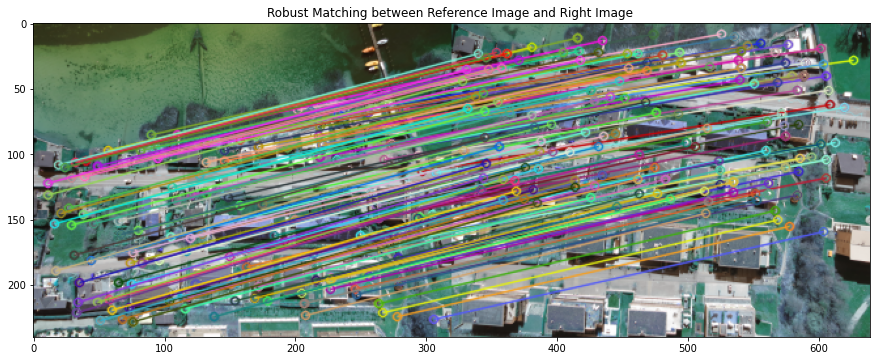

time: 346 ms (started: 2021-06-02 16:46:11 +00:00)


In [172]:
#dispimg1=cv2.drawMatches(img1,to_kpts(kp1.detach().numpy()), img2, to_kpts(kp2.detach().numpy()), matches[:50], None,(0,255,0),flags=2)
displayplot(dispimg,'Robust Matching between Reference Image and Right Image ')

In [173]:
points_all_left=[]
points_all_left.append(kp1)
points_all_left.append(kp2)

descriptors_all_left = []
descriptors_all_left.append(des1)
descriptors_all_left.append(des2)

time: 19.3 ms (started: 2021-06-02 16:49:32 +00:00)


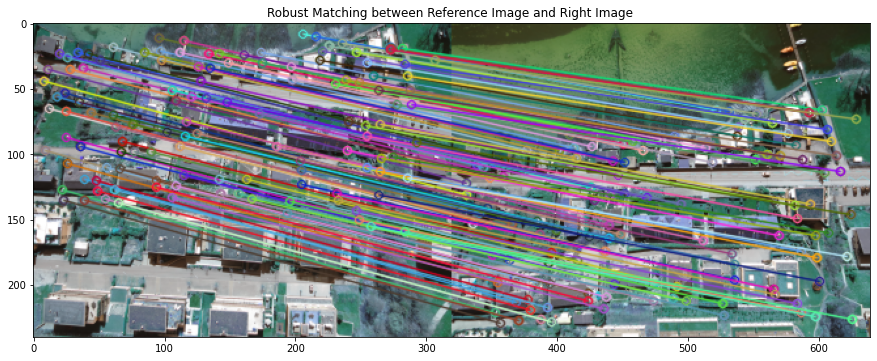

time: 401 ms (started: 2021-06-02 17:00:54 +00:00)


In [188]:
H_a = get_Hmatrix_rfnet(images_left_bgr[0:2][::-1],points_all_left[0:2][::-1],descriptors_all_left[0:2][::-1])

In [196]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[2], pt[1], size) for pt in pts]

time: 1.53 ms (started: 2021-06-02 17:11:32 +00:00)


## **Now Extracting Keypoints and Descriptors from all images and storing them**

In [195]:
images_left = []
descriptors_all_left = []
points_all_left=[]

images_right = []
descriptors_all_right = []
points_all_right=[]

for lfpth in tqdm(left_files_path):
  kp1, des1, img1 = model.detectAndCompute(lfpth, device, (240, 320))
  descriptors_all_left.append(des1)
  points_all_left.append(kp1)
  images_left.append(reverse_img(img1))


for rfpth in tqdm(left_files_path):
  kp1, des1, img1 = model.detectAndCompute(rfpth, device, (240, 320))
  descriptors_all_right.append(des1)
  points_all_right.append(kp1)
  images_right.append(reverse_img(img1))

/content/rfnet/model/rf_det_module.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  None, None, :, :
/content/rfnet/model/rf_net_so.py:165: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1004.)
  cos = cos.masked_select(im_topk)  # (B*topk)
/content/rfnet/model/rf_net_so.py:166: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1004.)
  sim = sim.masked_select(im_topk)  # (B*topk)
/content/rfnet/model/rf_net_so.py:170: UserWarning: masked_select received a mask with dt


time: 43.6 s (started: 2021-06-02 17:09:18 +00:00)


## **Image Matching (Robust) through Homography Matrix computation (No RANSAC)**

In [189]:

def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]






time: 33.8 ms (started: 2021-06-02 17:01:24 +00:00)


In [ ]:
#!pip install numba  # pip

In [124]:
print(img1.shape)

torch.Size([1, 1, 240, 320])
time: 999 µs (started: 2021-06-02 16:19:55 +00:00)


In [ ]:
print(len(images_left))

6
time: 854 µs (started: 2021-06-01 12:30:18 +00:00)


In [ ]:
print(len(images_right))

6
time: 843 µs (started: 2021-06-01 12:30:27 +00:00)


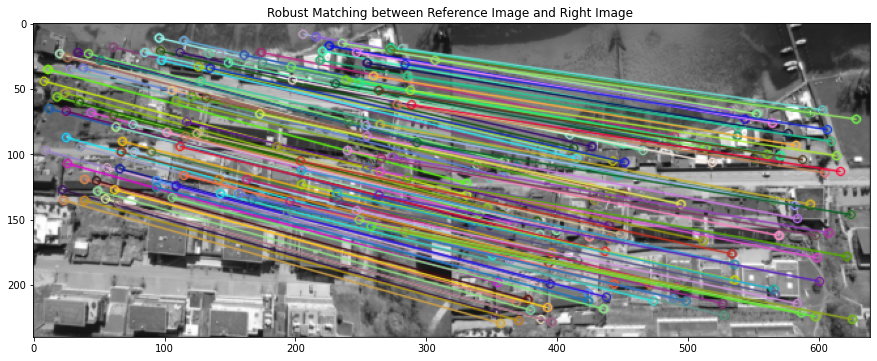

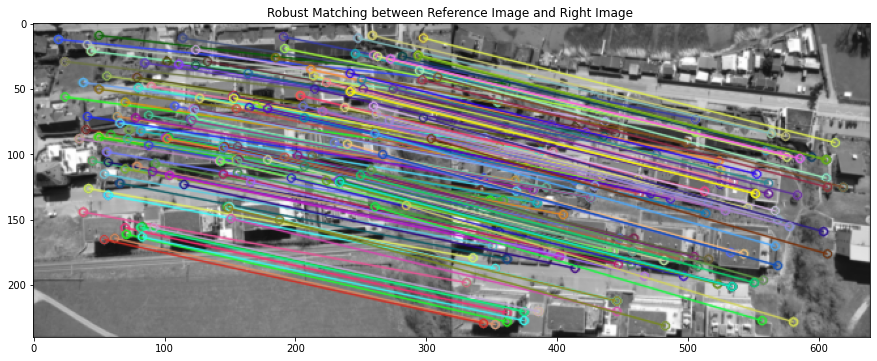

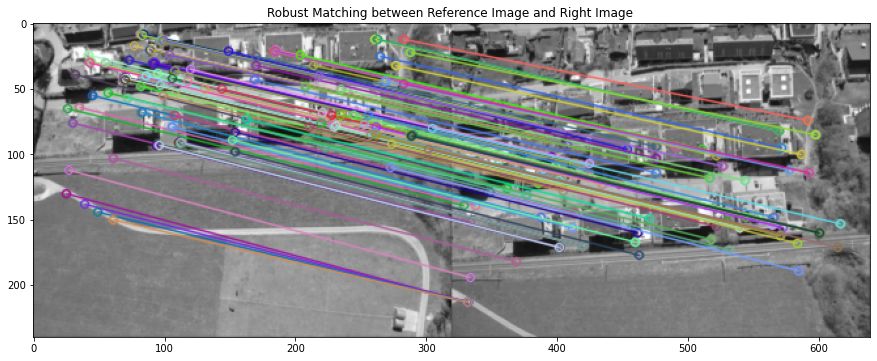

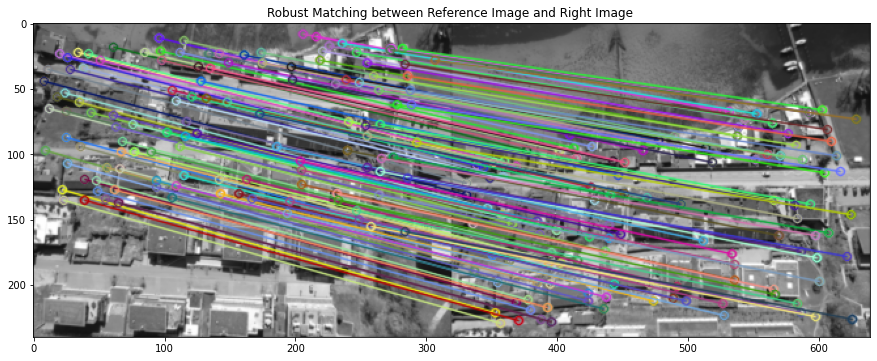

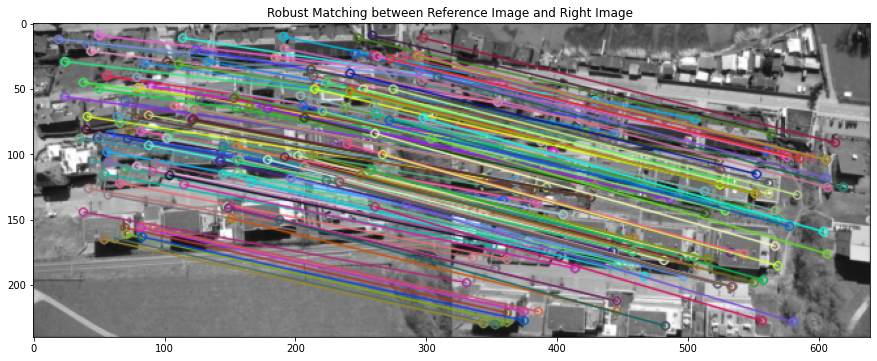

time: 2.03 s (started: 2021-06-02 17:12:31 +00:00)


In [197]:
H_left = []
H_right = []
poor_match_index_left = []
poor_match_index_right = []

for j in tqdm(range(len(images_left_bgr))):
  #print(j)
  if j==len(images_left_bgr)-1:
    break

  H_a = get_Hmatrix_rfnet(images_left[j:j+2][::-1],points_all_left[j:j+2][::-1],descriptors_all_left[j:j+2][::-1])

  #if len2<34:
  #  poor_match_index_left.append(j+1)
  #  continue

  H_left.append(H_a)

for j in tqdm(range(len(images_right_bgr))):
  if j==len(images_right_bgr)-1:
    break

  H_a = get_Hmatrix_rfnet(images_right[j:j+2][::-1],points_all_right[j:j+2][::-1],descriptors_all_right[j:j+2][::-1])

  #if len2<34:
  #  poor_match_index_right.append(j+1)
  #  continue


  H_right.append(H_a)


In [198]:
print(len(H_left),len(H_right))

3 2
time: 1.48 ms (started: 2021-06-02 17:13:04 +00:00)


## **Perspective Transformation b/w consecutive pairs through the computed Homography Matrices**

In [199]:
def warpnImages(images_left, images_right,H_left,H_right,poor_match_index_left,poor_match_index_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]

    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')

    warp_imgs_left = []
    warp_imgs_right = []


    for j,H in enumerate(H_left):
      #print(j)
      #if j ==2:
        #result = cv2.warpPerspective(images_left[j+2], H_trans, (xmax-xmin, ymax-ymin))
        #warp_imgs_left.append(result)
      #  continue
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H


      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))
      #plt.imshow(result)
      #plt.show()


      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)
    


    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H

      if j in poor_match_index_right:
        result = cv2.warpPerspective(images_right[j+2], H_trans, (xmax-xmin, ymax-ymin))
        warp_imgs_right.append(result)
        continue

      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step3:Done')

    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]

    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      #if j==1:
      #  continue
      
      warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      warp_img_init = warp_final
      #print(j)
      
      #plt.imshow(warp_final)
      #plt.show()

      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_final








  

time: 160 ms (started: 2021-06-02 17:13:07 +00:00)


In [200]:
combined_warp_n = warpnImages(images_left, images_right,H_left,H_right,poor_match_index_left,poor_match_index_right)

Step1:Done
Step2:Done
Step3:Done
Step4:Done
time: 15.4 ms (started: 2021-06-02 17:13:26 +00:00)


## **Final Mosaiced Image (with 6 images)**

Text(0.5, 1.0, '6-Images Mosaic - BGR')

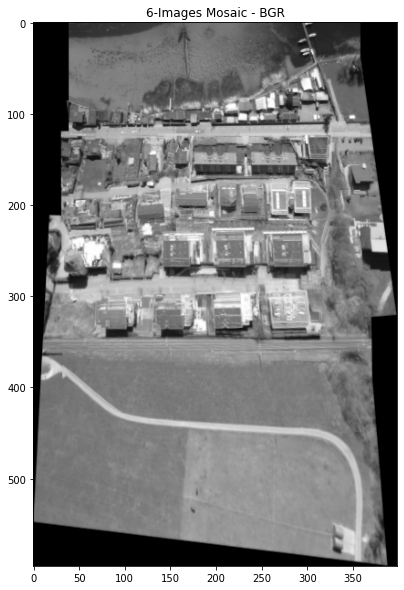

time: 297 ms (started: 2021-06-02 17:13:29 +00:00)


In [201]:
plt.figure(figsize = (20,10))


plt.imshow(combined_warp_n)
plt.title('6-Images Mosaic - Gray')

## **Observation**

The Mosaicied image looks similar as that obtained from R2D2 and SuperPoint features.

## **To Do Tasks:**

*   Introduce Geo-Referencing into the stitching pipleine
*   Create a graph-method to pre-select images with good matches because of possibility of poor-matches during linear search. (Auto-Filling). It helps cases wherein if there exist poor matches b/w image-pairs-not to skip the image-entirely but check if it has a better matching with another image.







## **References**

https://github.com/Xylon-Sean/rfnet

https://arxiv.org/pdf/1906.00604.pdf

